# Low-shot visual anomaly detection

In this notebook you'll investigate visual anomaly detection in a typical industrial setting - we don't have much data and we can train using only normal (non-anomalous) examples.
Read the [PADIM paper](https://arxiv.org/pdf/2011.08785.pdf) carefully.
The code here is based on the original implementation from its authors.

If you have any questions - please write them on slack in the channel.

### Bibliography

1. Defard, T., Setkov, A., Loesch, A., & Audigier, R. (2021). [Padim: a patch distribution modeling framework for anomaly detection and localization](https://arxiv.org/pdf/2011.08785.pdf). In International Conference on Pattern Recognition (pp. 475-489). Cham: Springer International Publishing.

## Data

In case of any problems - please visit [MVTec AD](https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads) to get the access to the data.

In [1]:
#If you received Too many users have viewed… error during downloading the MVTec AD dataset, you may want to use the following instead of !gdown:
!wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz
!wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz
!wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938166-1629953277/transistor.tar.xz

In [2]:
# %pip install --quiet gdown  # for those who don't run it on Google Colab
# !gdown -q '1r7WJeDb-E5zzgQSOx7F7bNWg8kYX3yKE'
# !gdown -q '1Kb420ygkN1iBni5Iy_-psLGNoY0gQFk9'
# !gdown -q '12wDP9I3aVIr1qLekWY3GLhQO7c6SRhGn'

In [16]:
from pathlib import Path
import tarfile

DATA_PATH = Path('./mvtec_anomaly_detection')
DATA_PATH.mkdir(exist_ok=True)

for class_name in ['bottle', 'metal_nut', 'transistor']:
    if not (DATA_PATH / class_name).exists():
        with tarfile.open(class_name + '.tar.xz') as tar:
            tar.extractall(path=DATA_PATH)

## PADIM implementation

### Imports and such

In [4]:
!pip install memory-profiler --quiet
%load_ext memory_profiler
from memory_profiler import memory_usage
import gc

In [3]:
import os
import random
import time
from pathlib import Path
from random import sample
from typing import cast, Any, Dict, List, Optional, Tuple

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends, torch.backends.mps
import torch.nn.functional as F
from numpy.typing import NDArray
from matplotlib import colors
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.segmentation import mark_boundaries
from torch.utils.data import DataLoader, Dataset
from torchvision.models import wide_resnet50_2, resnet18, Wide_ResNet50_2_Weights, ResNet18_Weights
from torch import nn
from torchvision import transforms as T
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler

FloatNDArray = NDArray[np.float32]

In [8]:
# Leave it as is if you're unsure, this notebook will guess this for you below.
DEVICE: Optional[torch.device] = None
SEED: int = 42  # do not modify

plt.style.use("dark_background")

In [9]:
def seed_all(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_best_device_for_pytorch() -> torch.device:
    if torch.cuda.is_available():
        device_str = "cuda"     # GPU
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device_str = "mps"      # Apple silicon
    else:
        device_str = "cpu"      # CPU
    return torch.device(device_str)

In [10]:
if not DEVICE:
    DEVICE = get_best_device_for_pytorch()
print(f"Using PyTorch with {DEVICE} backend.")

seed_all(SEED)
print(f"Seeded everything with {SEED}.")

Using PyTorch with cpu backend.
Seeded everything with 42.


### MVTecDataset

In [15]:
class MVTecDataset(Dataset[Tuple[torch.Tensor, int, torch.Tensor]]):
    """MVTec dataset of industrial objects with and without anomalies.

    Yields (x, y, mask) tuples where:
    - x is an RGB image from the class, as float tensor of shape (3, cropsize, cropsize);
    - y is an int, 0 for good images, 1 for anomalous images;
    - mask is 0 for normal pixels, 1 for anomalous pixels, as float tensor of shape (1, cropsize, cropsize).

    Source: https://github.com/xiahaifeng1995/PaDiM-Anomaly-Detection-Localization-master/blob/main/datasets/mvtec.py
    """

    def __init__(self, dataset_path: Path, class_name: str = 'bottle',
                 is_train: bool = True, resize: int = 256, cropsize: int = 224, return_only_indices=False):
        self.dataset_path = dataset_path
        self.class_name = class_name
        assert (dataset_path / class_name).is_dir(), f'Dataset class not found: {dataset_path / class_name}'
        self.is_train = is_train

        self.resize = resize
        self.cropsize = cropsize

        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()

        # set transforms
        self.transform_x = T.Compose([T.Resize(resize, Image.LANCZOS),
                                      T.CenterCrop(cropsize),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
        self.transform_mask = T.Compose([T.Resize(resize, Image.NEAREST),
                                         T.CenterCrop(cropsize),
                                         T.ToTensor()])

        self.return_only_indices = return_only_indices

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, torch.Tensor]:
        if self.return_only_indices:  # Used for checking the answer of T1.1.
            return idx

        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]

        x = Image.open(x).convert('RGB')
        x = cast(torch.Tensor, self.transform_x(x))

        if y == 0:
            mask = torch.zeros([1, self.cropsize, self.cropsize])
        else:
            assert mask is not None
            mask = Image.open(mask)
            mask = cast(torch.Tensor, self.transform_mask(mask))

        return x, y, mask

    def __len__(self) -> int:
        return len(self.x)

    def load_dataset_folder(self) -> Tuple[List[Path], List[int], List[Optional[Path]]]:
        phase = 'train' if self.is_train else 'test'
        x: List[Path] = []
        y: List[int] = []
        mask: List[Optional[Path]] = []

        img_dir = self.dataset_path / self.class_name / phase
        gt_dir = self.dataset_path / self.class_name / 'ground_truth'

        for img_type_dir in sorted(img_dir.iterdir()):
            # Load images.
            if not img_type_dir.is_dir():
                continue
            img_fpath_list = sorted(img_type_dir.glob('*.png'))
            x.extend(img_fpath_list)

            # Load ground-truth labels and masks.
            if img_type_dir.name == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                mask.extend([gt_dir / img_type_dir.name / (f.stem + '_mask.png')
                            for f in img_fpath_list])

        assert len(x) == len(y) == len(mask), 'Number of x, y, and mask should be the same.'
        return x, y, mask

### Auxilary functions

In [17]:
def sample_idx(number_of_features: int, max_number_of_features: int) -> torch.Tensor:
    assert number_of_features <= max_number_of_features
    return torch.tensor(sample(range(0, max_number_of_features), number_of_features))


def denormalization(x: FloatNDArray) -> NDArray[np.uint8]:
    """Denormalize with ImageNet values."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)


def embedding_concat(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Concatenate embeddings (along the channel dimension, upscaling y to match x).

    Args:
        x: Tensor of shape (B, C1, H1, W1).
        y: Tensor of shape (B, C2, H2, W2).

    Returns:
        Tensor of shape is (B, C1 + C2, H1, W1).
    """
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, s * s, H2, W2)
    z = torch.zeros(B, C1 + C2, s * s, H2, W2).to(x.device)
    for i in range(s * s):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), dim=1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
    return z

def concatenate_embeddings_from_all_layers(layer_outputs: Dict[str, torch.Tensor]) -> torch.Tensor:
        embedding_vectors = layer_outputs['layer1']
        for layer_name in ['layer2', 'layer3']:
            embedding_vectors = embedding_concat(embedding_vectors, layer_outputs[layer_name])
        return embedding_vectors

def plot_fig(test_img, scores, gts, threshold: float, save_dir: Path, class_name: str):
    num = len(scores)
    vmax = scores.max() * 255.
    vmin = scores.min() * 255.
    for i in range(num):
        img = test_img[i]
        img = denormalization(img)
        gt = gts[i].transpose(1, 2, 0).squeeze()
        heat_map = scores[i] * 255
        mask = scores[i]
        mask[mask > threshold] = 1
        mask[mask <= threshold] = 0
        kernel = morphology.disk(4)
        mask = morphology.opening(mask, kernel)
        mask *= 255
        vis_img = mark_boundaries(img, mask, color=(1, 0, 0), mode='thick')
        fig_img, ax_img = plt.subplots(1, 5, figsize=(12, 3))
        fig_img.subplots_adjust(right=0.9)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)
        ax_img[0].imshow(img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax = ax_img[2].imshow(heat_map, cmap='jet', norm=norm)
        ax_img[2].imshow(img, cmap='gray', interpolation='none')
        ax_img[2].imshow(heat_map, cmap='jet', alpha=0.5, interpolation='none')
        ax_img[2].title.set_text('Predicted heat map')
        ax_img[3].imshow(mask, cmap='gray')
        ax_img[3].title.set_text('Predicted mask')
        ax_img[4].imshow(vis_img)
        ax_img[4].title.set_text('Segmentation result')
        left = 0.92
        bottom = 0.15
        width = 0.015
        height = 1 - 2 * bottom
        rect = [left, bottom, width, height]
        cbar_ax = fig_img.add_axes(rect)
        cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
        cb.ax.tick_params(labelsize=8)
        font = {
            'family': 'serif',
            'color': 'black',
            'weight': 'normal',
            'size': 8,
        }
        cb.set_label('Anomaly Score', fontdict=font)

        fig_img.savefig(save_dir / f'{class_name}_{i}', dpi=100)
        plt.close()

In [18]:
def get_feature_extractor(arch: str) -> nn.Module:
    if arch == 'resnet18':
        model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1, progress=True)
        # t_d = 448
        # d = 40
    elif arch == 'wide_resnet50_2':
        model = wide_resnet50_2(weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1, progress=True)
        # t_d = 1792
        # d = 550
    else:
        raise NotImplementedError
    return model

### PADIM class

In [19]:
class PADIM():

    def __init__(
            self,
            backbone: str,
            device: torch.device,
            save_path: Path,
            backbone_features_idx: torch.Tensor,
            class_names: List[str] = ["bottle"],
            plot_metrics: bool = False,
    ) -> None:
        self.arch = backbone
        self.device = device
        self.model = get_feature_extractor(backbone)
        self.model.to(device)
        self.model.eval()

        self.feature_subset_indices = backbone_features_idx
        self.feature_subset_indices.to(device)

        self.outputs: Dict[str, torch.Tensor] = {}

        self.class_names = class_names
        self.save_path = save_path
        self.plot_metrics = plot_metrics

        self.setup_hooks()
        (self.save_path / f'temp_{self.arch}').mkdir(parents=True, exist_ok=True)

        self.mean: FloatNDArray  # shape (C, H * W)
        self.cov: FloatNDArray  # shape (C, C, H * W)

    def setup_hooks(self):
        """Setup hooks to store model's intermediate outputs."""
        self.model.layer1[-1].register_forward_hook(lambda _, __, x: self.outputs.update({'layer1': x}))
        self.model.layer2[-1].register_forward_hook(lambda _, __, x: self.outputs.update({'layer2': x}))
        self.model.layer3[-1].register_forward_hook(lambda _, __, x: self.outputs.update({'layer3': x}))

    def train_and_test(self, train_dataloader: DataLoader, test_dataloader: DataLoader) -> float:
        self.train(train_dataloader)
        return self.test(test_dataloader)

    def train(self, train_dataloader: DataLoader) -> None:
        self.train_outputs: Dict[str, List[torch.Tensor]] = {'layer1': [], 'layer2': [], 'layer3': []}
        for x, _, _ in tqdm(train_dataloader, desc='Feature extraction (train)'):
            # Run model prediction.
            with torch.no_grad():
                _ = self.model(x.to(DEVICE))
            # Get intermediate layer outputs.
            assert list(self.outputs.keys())  == ['layer1', 'layer2', 'layer3'], list(self.outputs.keys())
            for k, v in self.outputs.items():
                self.train_outputs[k].append(v.cpu().detach())
            # Reset hook outputs.
            self.outputs = {}

        embedding_vectors = concatenate_embeddings_from_all_layers(
            {k: torch.cat(v, 0) for k, v in self.train_outputs.items()})
        embedding_vectors_subset = torch.index_select(embedding_vectors, 1, self.feature_subset_indices.cpu())

        self.mean, self.cov = self.estimate_multivariate_gaussian(embedding_vectors_subset)
        del(self.train_outputs)

    def estimate_multivariate_gaussian(self, embedding_vectors: torch.Tensor
                                       ) -> Tuple[FloatNDArray, FloatNDArray]:
        """Calculates multivariate Gaussian distribution.

        Takes embeddings of shape (N, C, H, W).
        Returns (mean, covariance) of shape (C, H * W) and (C, C, H * W) respectively.
        """
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W)
        mean = torch.mean(embedding_vectors, dim=0).numpy()
        cov = torch.zeros(C, C, H * W).numpy()
        I = np.identity(C)
        for i in tqdm(range(H * W), desc="Covariance estimation"):
            cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I
        return mean, cov

    def test(self, test_dataloader: DataLoader) -> float:
        self.test_outputs: Dict[str, List[torch.Tensor]] = {'layer1': [], 'layer2': [], 'layer3': []}
        test_imgs: List[FloatNDArray] = []
        gt_list: List[NDArray[Any]] = []
        gt_mask_list: List[FloatNDArray] = []

        # Extract test set features.
        for x, y, mask in tqdm(test_dataloader, desc='Feature extraction (test)', disable=False):
            x_shape = x.shape
            test_imgs.extend(x.cpu().detach().numpy())
            gt_list.extend(y.cpu().detach().numpy())
            gt_mask_list.extend(mask.cpu().detach().numpy())
            # Run model prediction.
            with torch.no_grad():
                _ = self.model(x.to(DEVICE))
            # Get intermediate layer outputs.
            assert list(self.outputs.keys())  == ['layer1', 'layer2', 'layer3']
            for k, v in self.outputs.items():
                self.test_outputs[k].append(v.cpu().detach())
            # Reset hook outputs.
            self.outputs = {}
        gt_mask = np.asarray(gt_mask_list)  # shape (len(test_dataset), 1, H, W)

        embedding_vectors = concatenate_embeddings_from_all_layers(
            {k: torch.cat(v, 0) for k, v in self.test_outputs.items()})
        # shape (len(test_dataset), len(feature_subset_indices), H1, W1)
        embedding_vectors_subset = torch.index_select(embedding_vectors, 1, self.feature_subset_indices.cpu())

        distances = self.calculate_distances(embedding_vectors_subset)
        score_map = self.prepare_anomaly_map((x_shape[2], x_shape[3]), distances)

        img_fpr, img_tpr, img_auroc = self.calculate_auroc_image_level(score_map, gt_list)
        pxl_fpr, pxl_tpr, pxl_auroc = self.calculate_auroc_pixel_level(score_map, gt_mask)

        if self.plot_metrics:
            print(f'[TEST] Image AUROC: {img_auroc:.3f}')
            print(f'[TEST] Pixel AUROC: {pxl_auroc:.3f}')
            threshold = self.calculate_optimal_threshold(score_map, gt_mask)
            self.plot_test_results_for_class(gt_mask_list, test_imgs, score_map, threshold, img_fpr, img_tpr, img_auroc, pxl_fpr, pxl_tpr, pxl_auroc)

        return pxl_auroc


    # TODO: Some of your code for Task 1 goes here. You can add more functions if needed, but use the ones below - we will use them for checking your solution.
    def test_permutation_importance(self, val_dataloader: DataLoader, features_to_permute: List[int]) -> List[float]:
        """Runs a series of tests on `val_dataloader`.
        Returns a list of pixelwise AUROCs, where the n-th element of the list is generated by testing the embeddings from `permute_feature(embeddings, n)."""
        self.test_outputs: Dict[str, List[torch.Tensor]] = {'layer1': [], 'layer2': [], 'layer3': []}
        test_imgs: List[FloatNDArray] = []
        gt_list: List[NDArray[Any]] = []
        gt_mask_list: List[FloatNDArray] = []

        # Extract test set features.
        for x, y, mask in tqdm(test_dataloader, desc='Feature extraction (test)', disable=False):
            x_shape = x.shape
            test_imgs.extend(x.cpu().detach().numpy())
            gt_list.extend(y.cpu().detach().numpy())
            gt_mask_list.extend(mask.cpu().detach().numpy())
            # Run model prediction.
            with torch.no_grad():
                _ = self.model(x.to(DEVICE))
            # Get intermediate layer outputs.
            assert list(self.outputs.keys())  == ['layer1', 'layer2', 'layer3']
            for k, v in self.outputs.items():
                self.test_outputs[k].append(v.cpu().detach())
            # Reset hook outputs.
            self.outputs = {}
        gt_mask = np.asarray(gt_mask_list)  # shape (len(test_dataset), 1, H, W)

        embedding_vectors = concatenate_embeddings_from_all_layers(
            {k: torch.cat(v, 0) for k, v in self.test_outputs.items()})
        # shape (len(test_dataset), len(feature_subset_indices), H1, W1)

        #HERE CHANGED:
        result = []
        for j in features_to_permute:
          embedding_vectors_subset = torch.index_select(embedding_vectors, 1, self.feature_subset_indices.cpu())
          embedding_vectors_subset_permuted = permute_feature(embedding_vectors_subset, j)

          distances = self.calculate_distances(embedding_vectors_subset_permuted)
          score_map = self.prepare_anomaly_map((x_shape[2], x_shape[3]), distances)

          img_fpr, img_tpr, img_auroc = self.calculate_auroc_image_level(score_map, gt_list)
          pxl_fpr, pxl_tpr, pxl_auroc = self.calculate_auroc_pixel_level(score_map, gt_mask)

          result.append(pxl_auroc)
        return result


    def permute_feature(self, embedding_vectors_subset: torch.Tensor, number_of_feature_to_permute: int) -> torch.Tensor:
        """Permutes the embeddings.

        Takes embeddings of shape (N, C, H, W) and feature number to permute.
        Returns embeddings with the same shape. See the description of T1 for the details.
        """
        v = embedding_vectors_subset.numpy()
        (N, C, H, W) = v.shape
        shape = (N, H, W)

        rng = np.random.default_rng()
        v[:, number_of_feature_to_permute] = rng.permuted((v[:, number_of_feature_to_permute]).reshape(N, -1), axis = 1).reshape(shape)

        return embedding_vectors_subset
    # TODO: End of your code for Task 1 (here)

    def plot_test_results_for_class(self, gt_mask_list, test_imgs,
                                    score_map, threshold: float,
                                    img_fpr, img_tpr, img_auroc: float,
                                    pxl_fpr, pxl_tpr, pxl_auroc: float):
        _, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].plot(img_fpr, img_tpr, label=f'Image AUROC: {img_auroc:.3f}')
        ax[1].plot(pxl_fpr, pxl_tpr, label=f'Pixel AUROC: {pxl_auroc:.3f}')

        save_dir = self.save_path / f'pictures_{self.arch}'
        save_dir.mkdir(parents=True, exist_ok=True)
        plot_fig(test_imgs, score_map, gt_mask_list,
                 threshold, save_dir, "")

    def calculate_auroc_image_level(self, score_map: FloatNDArray, gt_list: List[NDArray[Any]]) -> Tuple[FloatNDArray, FloatNDArray, float]:
        """Calculate image-level AUROC score."""
        img_scores = score_map.reshape(score_map.shape[0], -1).max(axis=1)
        fpr, tpr, _ = roc_curve(gt_list, img_scores)  # false-positive-rates and true-positive-rates for consecutive thresholds (for plotting).
        img_auroc = roc_auc_score(gt_list, img_scores)
        return fpr, tpr, float(img_auroc)

    def calculate_auroc_pixel_level(self, score_map: FloatNDArray, gt_mask: FloatNDArray) -> Tuple[FloatNDArray, FloatNDArray, float]:
        """Calculate per-pixel level AUROC."""
        assert score_map.shape == gt_mask.squeeze().shape, f"{score_map.shape=}, {gt_mask.shape=}"
        fpr, tpr, _ = roc_curve(gt_mask.flatten(), score_map.flatten())
        per_pixel_auroc = roc_auc_score(gt_mask.flatten(), score_map.flatten())
        return fpr, tpr, float(per_pixel_auroc)

    def calculate_optimal_threshold(self, score_map: FloatNDArray, gt_mask: FloatNDArray) -> float:
        """Calculate the optimal threshold with regard to F1 score."""
        assert score_map.shape == gt_mask.squeeze().shape
        precision, recall, thresholds = precision_recall_curve(
            gt_mask.flatten(), score_map.flatten())
        a = 2 * precision * recall
        b = precision + recall
        f1 = np.divide(a, b, out=np.zeros_like(a), where=(b != 0))
        threshold = thresholds[np.argmax(f1)]
        return threshold

    def calculate_distances(self, embedding_vectors: torch.Tensor) -> FloatNDArray:
        """Calculate Mahalanobis distance of each embedding vector from self.mean.

        For embeddings of shape (N, C, H, W), returns shape (N, H, W).
        """
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
        dist_list: List[List[np.float64]] = []
        for i in range(H * W):
            mean = self.mean[:, i]
            conv_inv = np.linalg.inv(self.cov[:, :, i])
            dist = [mahalanobis(sample[:, i], mean, conv_inv)
                    for sample in embedding_vectors]
            dist_list.append(dist)

        return np.array(dist_list).transpose(1, 0).reshape(B, H, W)

    def prepare_anomaly_map(self, shape: Tuple[int, int], distances: FloatNDArray) -> FloatNDArray:
        """Upsample distances to `shape`, apply Gaussian smoothing, and normalize to [0,1].

        For distances of shape (N, H, W) and `shape` equal to (H2, W2), returns shape (N, H2, W2).
        """
        dists = torch.Tensor(distances).unsqueeze(1)
        shape = (dists.shape[0],) + shape
        score_map = cast(FloatNDArray, F.interpolate(
            dists, size=shape[2], mode='bilinear', align_corners=False).squeeze().numpy())
        for i in range(score_map.shape[0]):
            score_map[i] = gaussian_filter(score_map[i], sigma=4)

        min_score, max_score = score_map.min(), score_map.max()
        return (score_map - min_score) / (max_score - min_score + 1e-10)

### Let's see whether it works.
Take a look to the `SAVE_PATH` to inspect the results.

========== bottle


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]
Feature extraction (test): 100%|██████████| 42/42 [00:15<00:00,  2.75it/s]


[TEST] Image AUROC: 0.998
[TEST] Pixel AUROC: 0.981


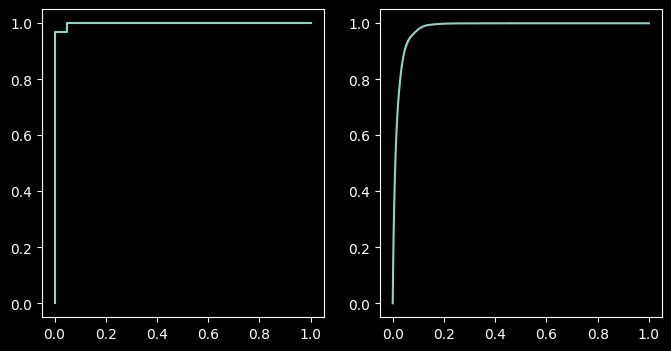

In [13]:
seed_all(SEED)
CLASS_NAMES = [
            'bottle', #'metal_nut'
            # 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
            # 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper'
        ]
BATCH_SIZE = 2
RESIZE = 256 * 1
CROP_SIZE = 224 * 1
BACKBONE = "resnet18"
NUMBER_OF_BACKBONE_FEATURES = 50
MAX_NUMBER_OF_BACKBONE_FEATURES = 448

run_timestamp = time.time()
for class_name in CLASS_NAMES:
    print('=' * 10, class_name)
    SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}")

    train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)
    test_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=False, resize=RESIZE, cropsize=CROP_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

    padim = PADIM(
        backbone=BACKBONE,
        device=DEVICE,
        backbone_features_idx=sample_idx(NUMBER_OF_BACKBONE_FEATURES, MAX_NUMBER_OF_BACKBONE_FEATURES),
        save_path=SAVE_PATH,
        plot_metrics=True,
    )

    padim.train_and_test(
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
    )

## permutations testing:

In [21]:
def permute_feature(embedding_vectors_subset: torch.Tensor, number_of_feature_to_permute: int) -> torch.Tensor:
        """Permutes the embeddings.

        Takes embeddings of shape (N, C, H, W) and feature number to permute.
        Returns embeddings with the same shape. See the description of T1 for the details.
        """
        v = embedding_vectors_subset.numpy()
        (N, C, H, W) = v.shape
        shape = (N, H, W)

        rng = np.random.default_rng()
        v[:, number_of_feature_to_permute] = rng.permuted((v[:, number_of_feature_to_permute]).reshape(N, -1), axis = 1).reshape(shape)

        return torch.from_numpy(v)
    # TODO: End of your code for Task 1 (here)

In [23]:
vector = torch.linspace(1, 90, 90).reshape(2, 5, 3, 3)
print(vector[:, 3, :, :])
print(vector[:, 4, :, :]) #not permuted
permute_feature(vector, 3)
print(vector[:, 3, :, :]) #permuted - for each image in different way
print(vector[:,4,:,:]) #not permuted
vector = None

tensor([[[28., 29., 30.],
         [31., 32., 33.],
         [34., 35., 36.]],

        [[73., 74., 75.],
         [76., 77., 78.],
         [79., 80., 81.]]])
tensor([[[37., 38., 39.],
         [40., 41., 42.],
         [43., 44., 45.]],

        [[82., 83., 84.],
         [85., 86., 87.],
         [88., 89., 90.]]])
tensor([[[33., 34., 35.],
         [36., 28., 29.],
         [30., 31., 32.]],

        [[77., 80., 81.],
         [76., 79., 74.],
         [73., 75., 78.]]])
tensor([[[37., 38., 39.],
         [40., 41., 42.],
         [43., 44., 45.]],

        [[82., 83., 84.],
         [85., 86., 87.],
         [88., 89., 90.]]])


# Task 1. Finding the right features (40%)

The authors of the paper argue that it doesn't really matter how we choose a subset of features. Let's make some steps towards exploring whether it's true for three different classes (`bottle`, `transistor`, `metal_nut`).
Design an experiment which will rank the ResNet18 features by its importance. To do so, we'll implement our variation of [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#outline-of-the-permutation-importance-algorithm) on a subset of features produced by the backbone.

### Settings

In [6]:
# do not modify
CLASS_NAMES = ['bottle', 'transistor', 'metal_nut']

BATCH_SIZE = 1
RESIZE = 256 * 2 // 4
CROP_SIZE = 224 * 2 // 4
BACKBONE = "resnet18"
NUMBER_OF_BACKBONE_FEATURES = 10
MAX_NUMBER_OF_BACKBONE_FEATURES = 100  # 448
folds = 3

In [11]:
seed_all(SEED)
results = {c: [0] * MAX_NUMBER_OF_BACKBONE_FEATURES for c in CLASS_NAMES}

run_timestamp = time.time()
print(f"{run_timestamp}")

idx_all_fatures = torch.Tensor(range(MAX_NUMBER_OF_BACKBONE_FEATURES)).int()
idx_all_features = idx_all_fatures
idx_first_n_features = torch.Tensor(range(NUMBER_OF_BACKBONE_FEATURES)).int()

dataloaders = {c: {"val_dataloader": None, "test_dataloader": None, "train_dataloaders": None} for c in CLASS_NAMES}

# TODO: Your code for T1.1, T1.2, and T1.3 goes below. Don't forget to write `test_permutation_importance` and `permute_feature` above in the PADIM code.

1702961399.118546


## My code:

## 1.1 Preparing the data

- Using the test dataset, create `val_dataloader` (every even sample from the original test dataset) and `test_dataloader` (every odd sample). `SubsetRandomSampler` might be handy here.
- Then, create 3-fold cross validation-like process in which you'll train PADIM on the first 100 ResNet features in three equally sized subsets of train dataset in which you discard 1/3 of the data ($\texttt{padim.train}(\texttt{train\_dataloader}_k)$) (see below). Again, `SubsetRandomSampler` might be handy here.

In other words, you should have:

- for $k=0$, the first 10 images indexes from the train dataset we should train on are `[1, 2, 4, 5, 7, 8, 10, 11, 13, 14]`,
- for $k=1$, that's `[0, 2, 3, 5, 6, 8, 9, 11, 12, 14]`,
- and for $k=2$, that's `[0, 1, 3, 4, 6, 7, 9, 10, 12, 13]`.

For val and train, you should have `[0, 2, 4, ...]` and `[1, 3, 5, ...]` respectively (from the test dataset).

Don't worry about the sampling order.
Use these names for DataLoaders `val_dataloader`, `test_dataloader`. For k-fold training, store dataloaders in `train_dataloaders: List[DataLoader]`, where each element represent different $k$.
For each class, store the results in `dataloaders` dictionary (defined below) - we will use this to check your solution.

In [22]:
for class_name in CLASS_NAMES:
  test_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=False, resize=RESIZE, cropsize=CROP_SIZE)
  test_indices = range(len(test_dataset))

  even_indices = [i for i in test_indices if i % 2 == 0]
  even_sampler = torch.utils.data.SubsetRandomSampler(even_indices)
  val_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, sampler=even_sampler, pin_memory=True)

  odd_indices = [i for i in test_indices if i % 2 == 1]
  odd_sampler = torch.utils.data.SubsetRandomSampler(odd_indices)
  test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, sampler=odd_sampler, pin_memory=True)

  dataloaders[class_name]["val_dataloader"] = val_dataloader
  dataloaders[class_name]["test_dataloader"] = test_dataloader


  train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
  train_indices = range(len(train_dataset))

  train_dataloaders = []
  K = folds
  for k in range(K):
    k_train_indices = [i for i in train_indices if i % K != k]
    k_train_sampler = torch.utils.data.SubsetRandomSampler(k_train_indices)
    k_train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=k_train_sampler, pin_memory=True)
    train_dataloaders.append(k_train_dataloader)

  dataloaders[class_name]["train_dataloaders"] = train_dataloaders

## 1.2 Calculating the importances

- In a given fold, each $j$-th feature shall be ranked based on the pixel-wise AUROC difference between the output of that model ($s_{k} \leftarrow \texttt{padim.test}(\texttt{val\_dataloader})$) and the output with the model with permuted $j$-th feature ($s_{k, j} \leftarrow \texttt{padim.test}(\texttt{val\_dataloader, feature\_to\_permute=}j)$). See also `test_permutation_importance` method stub above.
- Implement `permute_feature` method as follows: given the tensor with embeddings with shape `[B, C, H, W]`, by permutation of the $j$-th feature we mean randomly swapped values for $C=j$. The order of swapping shall be **different** for every image. In other words, for every image $b$ and feature $j$ you need to shuffle the last two dimensions (marked as stars in `[b, j, *, *]`) in an unique manner.
- Then, calculate the mean importance $i$ averaged on these folds and plot weights importance for the class ($i_j \leftarrow  \frac{1}{K} \sum_{k = 0}^{K-1} s_{k} - s_{k, j}$, where $K$ is the number of folds).
- Append results in `results` dictionary, where keys are class names and values are the lists of averaged feature importances (from feature 0 to feature 99).

In [27]:
run_timestamp = time.time()

for class_name in CLASS_NAMES:
  for k in range(folds):
    SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}")
    padim = PADIM(backbone=BACKBONE, device=DEVICE,
        backbone_features_idx=idx_all_features,
        save_path=SAVE_PATH, class_names=[class_name], plot_metrics=False)
    padim.train(dataloaders[class_name]["train_dataloaders"][k])

    s_k = padim.test(dataloaders[class_name]["val_dataloader"])
    s_k_js = padim.test_permutation_importance(dataloaders[class_name]["val_dataloader"], features_to_permute = idx_all_features)
    for j in idx_all_features:
      results[class_name][j] += ((s_k - s_k_js[j]) / folds)

Feature extraction (test): 100%|██████████| 57/57 [00:04<00:00, 11.70it/s]


In [28]:
# Save to file
for class_name in CLASS_NAMES:
  x = torch.tensor(results[class_name])
  torch.save(x, ('result_for_' + class_name))

In [13]:
##For problems with runtime:

# results = {c: [0] * MAX_NUMBER_OF_BACKBONE_FEATURES for c in CLASS_NAMES}
# results['bottle'] = torch.load('result_for_bottle')
# results['metal_nut'] = torch.load('result_for_metal_nut')
# results['transistor'] = torch.load('result_for_transistor')

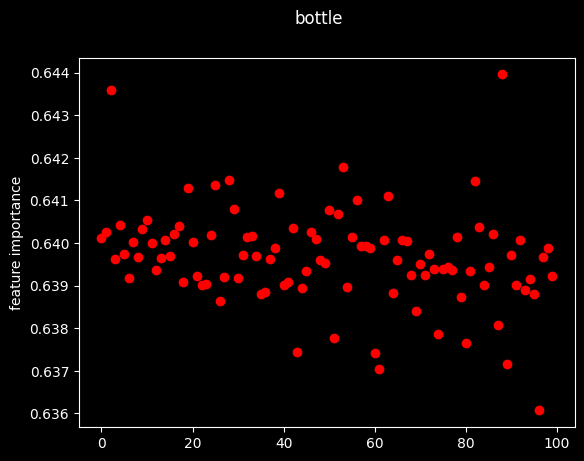

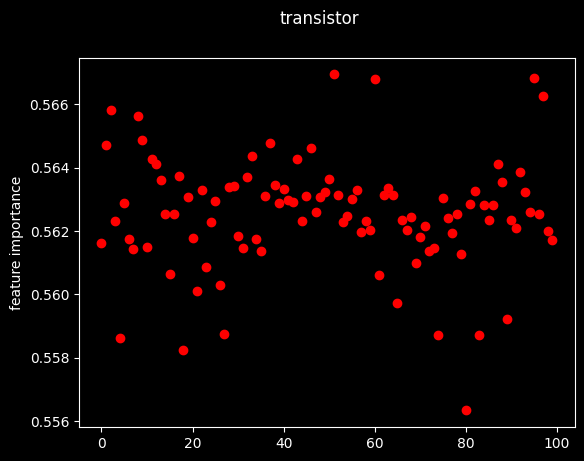

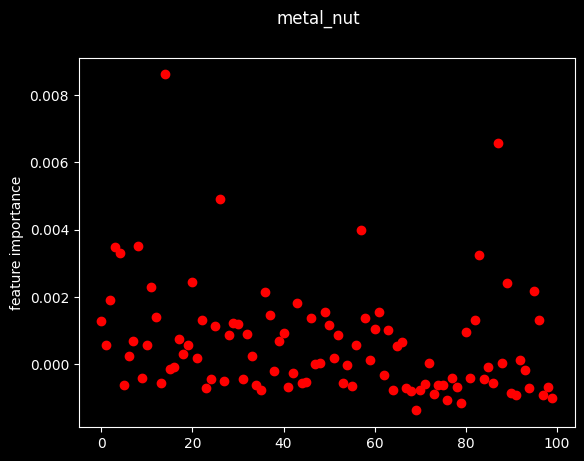

In [29]:
#plot feature importance:
for class_name in CLASS_NAMES:
  plt.plot(results[class_name], 'ro')
  plt.ylabel('feature importance')
  plt.suptitle(class_name)
  plt.show()

## 1.3 Drawing conclusions

- Finally, for every class train three models on the full training data and evaluate it on the `test_dataloader`. The first model shall use the first 10 features, the second shall use worst 10 features (in terms of feature importance), and the third shall contain the best 10 features.
- Write your conclusions (with the things enlisted below in mind). Simply plotting charts or outputting logs without any comment doesn't qualify as an answer to a question.

Note 1: Limit yourself to the first 100 features of ResNet18. If you want, you can go with all of available features instead of 100, but it'll take some time to calculate. Converting parts of the code to PyTorch and running on GPU might change a lot here, but this is not evaluated in this exercise. This experiment can be calculated without GPU in less than one hour anyway.

Note 2: If you'd like to be fully covered, one needs to explore if the features are correlated, as this might bias the results of feature importance calculations. However, this is not evaluated in this task for the sake of simplicity (that is, examining the 100 first features without worrying about correlated features are enough to get 100% from this task).

In [20]:
best_features = {c: [0] * NUMBER_OF_BACKBONE_FEATURES for c in CLASS_NAMES}
worst_features = {c: [0] * NUMBER_OF_BACKBONE_FEATURES for c in CLASS_NAMES}

for class_name in CLASS_NAMES:
  order = np.argsort(results[class_name]) #increasing

  worst_features[class_name] = list(order[:NUMBER_OF_BACKBONE_FEATURES])
  best_features[class_name] = list(order[-NUMBER_OF_BACKBONE_FEATURES:])

  #print(np.array(results[class_name])[order[:10]])
  #print(np.array(results[class_name])[order[-10:]])

Feature extraction (test): 100%|██████████| 41/41 [00:03<00:00, 12.09it/s]


[TEST] Image AUROC: 0.994
[TEST] Pixel AUROC: 0.970


Feature extraction (test): 100%|██████████| 41/41 [00:03<00:00, 10.65it/s]


[TEST] Image AUROC: 0.965
[TEST] Pixel AUROC: 0.971


Feature extraction (test): 100%|██████████| 41/41 [00:03<00:00, 12.13it/s]


[TEST] Image AUROC: 0.994
[TEST] Pixel AUROC: 0.971


Feature extraction (test): 100%|██████████| 50/50 [00:06<00:00,  7.67it/s]


[TEST] Image AUROC: 0.893
[TEST] Pixel AUROC: 0.956


Feature extraction (test): 100%|██████████| 50/50 [00:05<00:00,  9.38it/s]


[TEST] Image AUROC: 0.907
[TEST] Pixel AUROC: 0.949


Feature extraction (test): 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


[TEST] Image AUROC: 0.960
[TEST] Pixel AUROC: 0.962


Feature extraction (test): 100%|██████████| 57/57 [00:03<00:00, 14.41it/s]


[TEST] Image AUROC: 0.945
[TEST] Pixel AUROC: 0.938


Feature extraction (test): 100%|██████████| 57/57 [00:03<00:00, 14.95it/s]


[TEST] Image AUROC: 0.879
[TEST] Pixel AUROC: 0.923


Feature extraction (test): 100%|██████████| 57/57 [00:04<00:00, 13.75it/s]


[TEST] Image AUROC: 0.895
[TEST] Pixel AUROC: 0.862


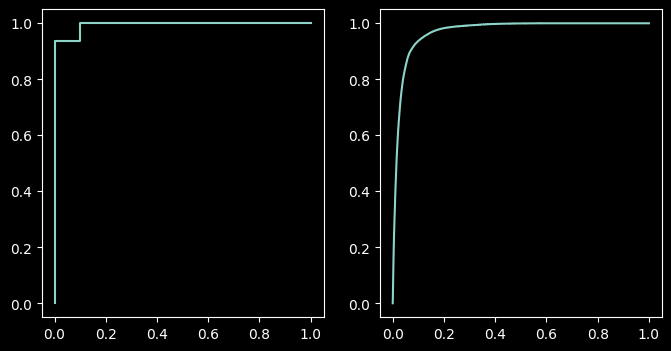

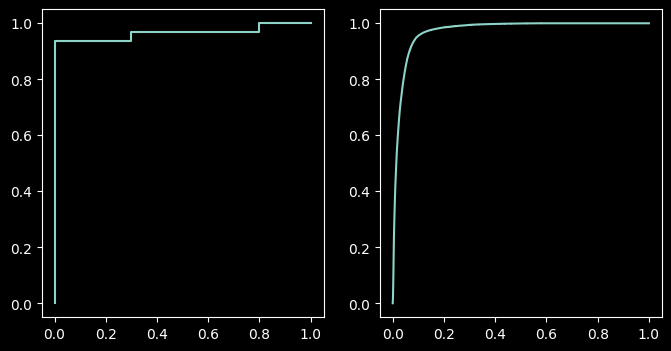

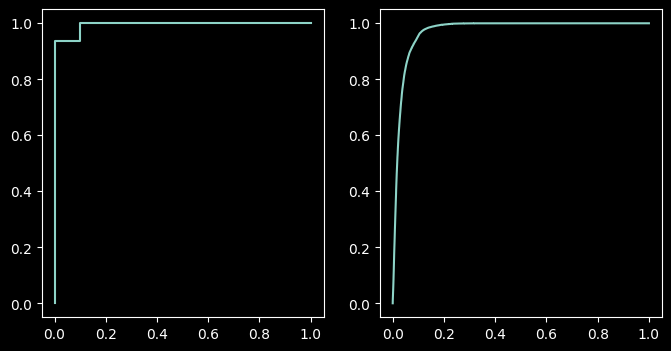

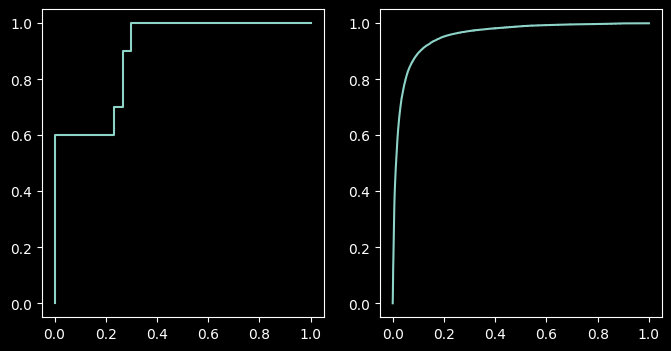

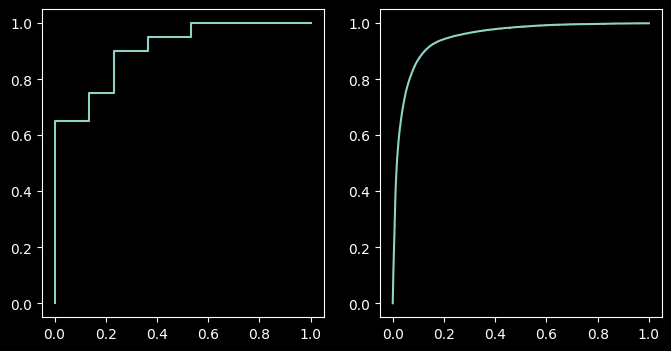

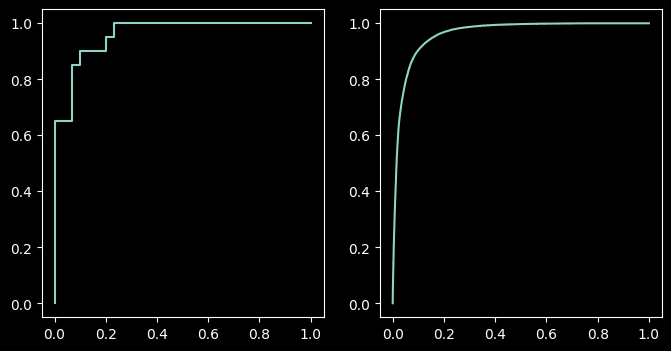

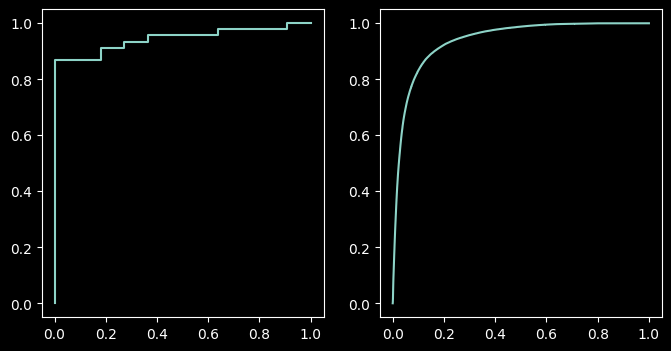

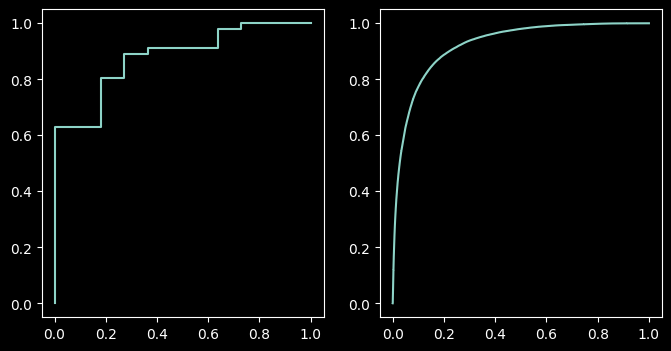

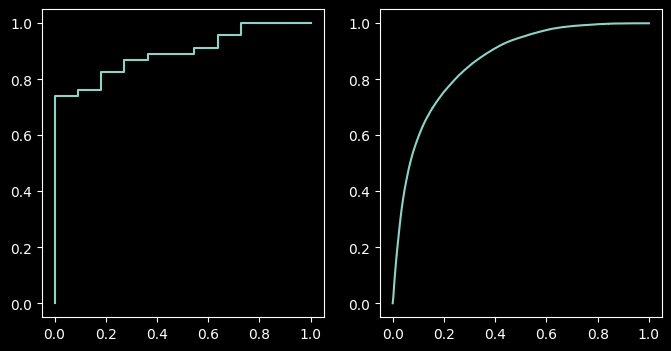

In [23]:
evaluations = {c: {"first": None, "best": None, "worst": None} for c in CLASS_NAMES}

run_timestamp = time.time()

for class_name in CLASS_NAMES:
  train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)

  SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}/{'first'}")
  padim_first = PADIM(backbone=BACKBONE, device=DEVICE,
    backbone_features_idx=idx_first_n_features,
    save_path=SAVE_PATH, class_names=[class_name], plot_metrics=True)
  padim_first.train(train_dataloader)

  SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}/{'best'}")
  padim_best = PADIM(backbone=BACKBONE, device=DEVICE,
    backbone_features_idx=torch.tensor(best_features[class_name]),
    save_path=SAVE_PATH, class_names=[class_name], plot_metrics=True)
  padim_best.train(train_dataloader)

  SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}/{'worst'}")
  padim_worst = PADIM(backbone=BACKBONE, device=DEVICE,
    backbone_features_idx=torch.tensor(worst_features[class_name]),
    save_path=SAVE_PATH, class_names=[class_name], plot_metrics=True)
  padim_worst.train(train_dataloader)

  evaluations[class_name]["first"] = padim_first.test(dataloaders[class_name]["test_dataloader"])
  evaluations[class_name]["best"] = padim_best.test(dataloaders[class_name]["test_dataloader"])
  evaluations[class_name]["worst"] = padim_worst.test(dataloaders[class_name]["test_dataloader"])

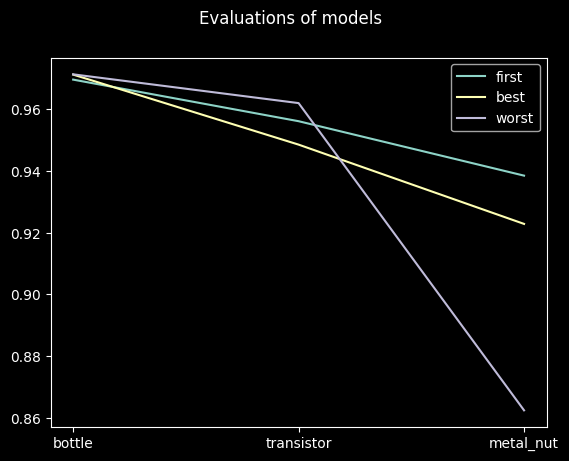

In [24]:
first = []
best = []
worst = []
for class_name in CLASS_NAMES:
  first.append(evaluations[class_name]["first"])
  best.append(evaluations[class_name]["best"])
  worst.append(evaluations[class_name]["worst"])

torch.save(torch.tensor(first), ('evaluation_of_first'))
torch.save(torch.tensor(best), ('evaluation_of_best'))
torch.save(torch.tensor(worst), ('evaluation_of_worst'))

fig, ax = plt.subplots()
fig.suptitle('Evaluations of models')
ax.plot(CLASS_NAMES, first, label="first")
ax.plot(CLASS_NAMES, best, label="best")
ax.plot(CLASS_NAMES, worst, label="worst")
ax.legend()

plt.show()


## Conclusions:

#### In each class all of the features have more or less the same importance(they are of the same order of magnitude), but according to my calculations those importances vary wildly across different classes (by about 3 orders of magnitude). It is not improbable as classes are different. Some classes may be more 'mixing invariant' - ie different patches are similar (or to be more precise the embeddings are similar), that may happen if the image doesn't have any distinctive features or if those feature across different images of that class are not placed in the same places - for example there might be some shifts and nontrivial rotations of the objects so that distributions don't change significantly between patches. And other classes might be opposite - that is for a certain patch its embeddings come from a narrow distribution - that may happen if the object stays relatively in place and is very similar across different images.
#### So there are 2 options: either that is really the case or there is some bug in my code (I am somewhat suspicious of such large differences in 'average' feature importance between classes).
#### Either way the choice of specific features doesn't have much impact on the performance of the model - they behave more or less the same for every class regardless of chosing set of worst or best or random (first). Or rather the models do a bit differently based on the set of features it learned, but there is no consistent advantage of any of them across all classes - the 'worst' model does the best on transistor and (ex aequo) on bottle, the first does the best on metal nut and (ex aequo) on bottle, and the ' best' isn't far behind.
#### On the other hand the number of features used in training does have some impact - the more the better. That isn't shocking - the backbone model was optimized for very different task (regarding different classes and possibly not localization/detection) so there is no reason for different features-chanels to be 'specialized' for specific class in mvtec dataset. Rather each channel does something that is generally (across classes) a bit useful and, combined together, this information allows to localize anomalies (possibly also for those different classes for which the backbone was actually trained there wasn't a clear specialization of features-chanels useful only for specific class, as usually there are more classes than chanels and lack of such specialization facilitates the model to score high for all classes).

## Assessment:

In [32]:
# Run at the end, but do not modify - we will use this to asses your output.
for c in CLASS_NAMES:
    s = pd.Series(results[c])
    print(s.sort_values(ascending=False)[:10].index.tolist())
    print(s.sort_values(ascending=True)[:10].index.tolist())

def get_sorted_indices(loader):
    loader.dataset.return_only_indices = True
    indices = sorted([x.item() for x in loader])
    loader.dataset.return_only_indices = False
    return indices

for c in CLASS_NAMES:
    print(get_sorted_indices(dataloaders[c]["val_dataloader"]))
    print(get_sorted_indices(dataloaders[c]["test_dataloader"]))
    for v in dataloaders[c]["train_dataloaders"]:
        print(get_sorted_indices(v))

[88, 2, 53, 28, 82, 25, 19, 39, 63, 56]
[96, 61, 89, 60, 43, 80, 51, 74, 87, 69]
[51, 95, 60, 97, 2, 8, 9, 37, 1, 46]
[80, 18, 4, 83, 74, 27, 89, 65, 21, 26]
[14, 87, 26, 57, 8, 3, 4, 83, 20, 89]
[69, 79, 76, 99, 91, 97, 73, 90, 68, 35]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82]
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81]
[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32, 34, 35, 37, 38, 40, 41, 43, 44, 46, 47, 49, 50, 52, 53, 55, 56, 58, 59, 61, 62, 64, 65, 67, 68, 70, 71, 73, 74, 76, 77, 79, 80, 82, 83, 85, 86, 88, 89, 91, 92, 94, 95, 97, 98, 100, 101, 103, 104, 106, 107, 109, 110, 112, 113, 115, 116, 118, 119, 121, 122, 124, 125, 127, 128, 130, 131, 133, 134, 136, 137, 139, 140, 142, 143, 145, 146, 148, 149, 151, 152, 

# Task 2. Improving PADIM with Online Covariance Estimation

#### 2.1. PADIM's training complexity (15%)

This implementation of PADIM can be improved in numerous ways. In this exercise, you'll try to indicate its shortcomings and provide some means to mitigate them.

- Identify the key operations contributing to the algorithm's training space complexity *in this implementation*. Don't focus on the backbone, as it is not the part of the algorithm (however, its output is).
- Shortly discuss the implications for scalability. You can support your claims by charts if needed.

*Hint: this doesn't need to be super formal analysis - it's about fiding the "worst" parts of this implementation. You can support your claims with a chart and brief description (e.g. "X dominates the complexity, as it's quadratic.")*

```Your answer to task 2.1 goes here```

In [140]:
# Your code goes here (if needed)

##### My answer
There are several inefficiencies in the training process:
1. As for memory complexity, a major inefficiency is storing activations of the relevant layers for ALL the images in order to compute the covariance matrix's and mean vector's estimations instead of doing it on the fly - that is updating those estimations with activations of each batch and 'forgeting' them right after that, as they are no longer used.
The original implementation in this notebook needed Θ(H * W * C * N + H * W * C' * C') memory, where H, W are image dimensions, C is the number of channels in the layers used (448 for resnet), C' is thecnumber of features used, and N is the number of images, while the implementation that would do the online estimations would use Θ(H * W * C * B + H * W * C' * C'), where B is the batch size, so it is independent of the size of the training dataset, contrary to the first former, which increases linearly with that size.
2. As for time and (somewhat) space complexity: for each image its embedding is found by doing the inference with the full model, that is propagating the activations all the way through all layers instead of finishing at the last useful layer (for ResNet it would be third layer, while ResNet is several times 'longer' - the greater is the proportion between the overall model length and the length from the first to the last used layer the greater the effect is) - that increases time complexity, while not having too much of an impact on space complexity as mode is in eval mode and doesn't use grad, so the activations dissapear (unless they are memorized as is the case with the first 3 layers)

#### 2.2 Online mean and covariance (35%)


Implement a PyTorch version of [online covariance matrix estimation](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Online) in the training as an alternative to the current method in PADIM.
Calculate the mean in an online fashion as well.
Your implementation shall run on the selected `torch.device` (such as GPU).
No need to reimplement the testing routine to online in this exercise (although it'd be nice to have for Task 1), albeit small changes might be necessary (such as conversion from `torch.Tensor` to `np.ndarray`).

Passing criteria:
```python
torch.allclose(padim_online.mean, torch.Tensor(padim_offline.mean).to(DEVICE), atol=0.01)
torch.allclose(padim_online.cov, torch.Tensor(padim_offline.cov).to(DEVICE), atol=0.01)
```


In [25]:
class PADIMWithOnlineCovariance(PADIM):

    ### TODO: Your code goes here
    def __init__(
            self,
            backbone: str,
            device: torch.device,
            save_path: Path,
            backbone_features_idx: List[int],
            class_names=...,
            plot_metrics=False,
            ) -> None:
        super().__init__(backbone, device, save_path, backbone_features_idx, class_names, plot_metrics)

    def train(self, train_dataloader: DataLoader, C: int, H: int, W: int):
        """C, H, W come from the size of embeddings: [B, C, H, W]"""

        mean = torch.zeros((C, H * W)).to(self.device)
        cov = torch.zeros((C, C, H * W)).to(self.device)
        n = 0

        for x, _, _ in tqdm(train_dataloader, desc='Feature extraction (train)'):
            self.train_outputs: Dict[str, List[torch.Tensor]] = {'layer1': [], 'layer2': [], 'layer3': []}
            # Run model prediction.
            with torch.no_grad():
                _ = self.model(x.to(self.device))
            # Get intermediate layer outputs.
            assert list(self.outputs.keys())  == ['layer1', 'layer2', 'layer3'], list(self.outputs.keys())
            for k, v in self.outputs.items():
                self.train_outputs[k].append(v.detach().to(self.device))
            # Reset hook outputs.
            self.outputs = {}

            embedding_vectors = concatenate_embeddings_from_all_layers({k: torch.cat(v, 0) for k, v in self.train_outputs.items()})
            del(self.train_outputs)

            embedding_vectors_subset = torch.index_select(embedding_vectors, 1, self.feature_subset_indices.to(self.device))
            for i in range(len(embedding_vectors_subset)):
                n += 1
                embedding_vect = embedding_vectors_subset[i].view(C, H * W)

                mean += ((embedding_vect - mean) / n)

                difference = embedding_vect - mean

                for i in range(H*W):
                    diff_v = (difference[:, i]).reshape(1, -1)
                    if n > 1:
                        cov[:, :, i] =((n-1) / n) * (cov[:, :, i]) +  (torch.matmul(diff_v.T, diff_v)) / (n-1)

        I = torch.eye(C).to(self.device)
        for i in range(H * W):
            cov[:, :, i] += 0.01 * I

        self.mean = mean.to(self.device)
        self.cov = cov.to(self.device)
    ### END OF YOUR CODE


In [34]:
# v = torch.tensor([[1, 2, 3],[3, 4, 5],[0,9,8]])
# len(v)

In [35]:
# do not modify
seed_all(SEED)
class_name = 'bottle'
BATCH_SIZE = 1
RESIZE = 256 * 1
CROP_SIZE = 224 * 1
BACKBONE = "resnet18"
NUMBER_OF_BACKBONE_FEATURES = 30
MAX_NUMBER_OF_BACKBONE_FEATURES = 448
# DEVICE="cpu"

indices = sample_idx(NUMBER_OF_BACKBONE_FEATURES, MAX_NUMBER_OF_BACKBONE_FEATURES).to(DEVICE)

run_timestamp = time.time()
SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}")

train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=False, resize=RESIZE, cropsize=CROP_SIZE)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)


padim_offline = PADIM(
    backbone=BACKBONE,
    device=DEVICE,
    backbone_features_idx=indices,
    save_path=SAVE_PATH,
    plot_metrics=True,
)
padim_offline.train(train_dataloader)

padim_online = PADIMWithOnlineCovariance(
    backbone=BACKBONE,
    device=DEVICE,
    backbone_features_idx=indices,
    save_path=SAVE_PATH,
    plot_metrics=True,
)
padim_online.train(train_dataloader, NUMBER_OF_BACKBONE_FEATURES, int(CROP_SIZE/4), int(CROP_SIZE/4))

torch.allclose(padim_online.mean, torch.Tensor(padim_offline.mean).to(DEVICE), atol=0.01) and torch.allclose(padim_online.cov, torch.Tensor(padim_offline.cov).to(DEVICE), atol=0.01)


Feature extraction (train): 100%|██████████| 209/209 [02:09<00:00,  1.62it/s]


True

#### 2.3 Performance experiments (10%)
If you completed task 2.2, design experiments to empirically compare `space/memory` performance of PADIM training with both traditional and online covariance matrix estimation. Write short conclusions.

In [36]:
# Your code goes here
import gc
padim_offline = None
padim_online = None

In [37]:
padim_offline = PADIM(backbone=BACKBONE, device=DEVICE, backbone_features_idx=indices, save_path=SAVE_PATH, plot_metrics=False)
gc.collect()
%reload_ext memory_profiler


%memit padim_offline.train(train_dataloader)

padim_offline = None

Covariance estimation: 100%|██████████| 3136/3136 [00:01<00:00, 2280.95it/s]


peak memory: 6761.39 MiB, increment: 3350.78 MiB


In [38]:
padim_online = PADIMWithOnlineCovariance(backbone=BACKBONE, device=DEVICE, backbone_features_idx=indices, save_path=SAVE_PATH, plot_metrics=False)
gc.collect()
%reload_ext memory_profiler


%memit padim_online.train(train_dataloader, NUMBER_OF_BACKBONE_FEATURES, int(CROP_SIZE/4), int(CROP_SIZE/4))

padim_online = None

Feature extraction (train): 100%|██████████| 209/209 [02:25<00:00,  1.44it/s]


peak memory: 3411.79 MiB, increment: 0.25 MiB


In [ ]:
train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
for i in range(2):
  sampler = torch.utils.data.RandomSampler(train_dataset, num_samples=((i+1) * len(train_dataset)))
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, pin_memory=True)

  padim_online = PADIMWithOnlineCovariance(backbone=BACKBONE, device=DEVICE, backbone_features_idx=indices, save_path=SAVE_PATH, plot_metrics=False)
  print("online" + str(i))
  gc.collect()
  %reload_ext memory_profiler
  %memit padim_online.train(train_dataloader, NUMBER_OF_BACKBONE_FEATURES, int(CROP_SIZE/4), int(CROP_SIZE/4))
  padim_online = None

  padim_offline = PADIM(backbone=BACKBONE, device=DEVICE, backbone_features_idx=indices, save_path=SAVE_PATH, plot_metrics=False)
  print("offline" + str(i))
  gc.collect()
  %reload_ext memory_profiler


  %memit padim_offline.train(train_dataloader)

  padim_offline = None

online0


Feature extraction (train): 100%|██████████| 209/209 [02:14<00:00,  1.55it/s]


peak memory: 3411.84 MiB, increment: 0.00 MiB
offline0


Covariance estimation: 100%|██████████| 3136/3136 [00:01<00:00, 2500.72it/s]


peak memory: 6747.78 MiB, increment: 3335.93 MiB
online1


Feature extraction (train): 100%|██████████| 418/418 [04:05<00:00,  1.70it/s]


peak memory: 3411.91 MiB, increment: 0.06 MiB
offline1


Covariance estimation: 100%|██████████| 3136/3136 [00:01<00:00, 1710.59it/s]


peak memory: 10116.82 MiB, increment: 6704.91 MiB
online2


Feature extraction (train): 100%|██████████| 627/627 [06:57<00:00,  1.50it/s]


peak memory: 3261.98 MiB, increment: 9.11 MiB
offline2


Feature extraction (train): 100%|██████████| 627/627 [02:28<00:00,  4.22it/s]


```Your conclusions go here```

#### My conclusions:


##### Already with the dataset containing 209 images the difference between online and ofline versions is noticeable and gets bigger with the increase of the dataset size as there is a linear overhead for the offline version due to storing all the embeddings until computing the estimations for means and covariance matrices at once at the end (in online version only one batch of these is stored at any time) apart from some constant amount required that is the same for both implementations (mainly for storing covariance matrices)
##### Experiments cofirm those conjectures, as the memory complexity of the online model stays more or less the same regardless of increasing the number of images (artificially), while that of the offline model scales linearly, to the point that colab runtime has crushed in the 3rd loop due to lack of RAM

#### 2.4 Bonus task (optional)
You can also add similar experiments with conclusions with regard to the `time` complexity. This task is optional, but if you'll loose points elsewhere, this can help you to make up for some of them.

In [37]:
train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)

In [42]:
padim_offline = PADIM(backbone=BACKBONE, device=DEVICE, backbone_features_idx=indices, save_path=SAVE_PATH, plot_metrics=False)
gc.collect()

%timeit padim_offline.train(train_dataloader)

Covariance estimation: 100%|██████████| 3136/3136 [00:01<00:00, 1661.75it/s]


45.3 s ± 1.21 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
padim_online = PADIMWithOnlineCovariance(backbone=BACKBONE, device=DEVICE, backbone_features_idx=indices, save_path=SAVE_PATH, plot_metrics=False)
gc.collect()

%timeit padim_online.train(train_dataloader, NUMBER_OF_BACKBONE_FEATURES, int(CROP_SIZE/4), int(CROP_SIZE/4))

Feature extraction (train): 100%|██████████| 209/209 [02:14<00:00,  1.55it/s]

1min 58s ± 7.64 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Time complexity is 2.5 times greater for online models than for offline models according to experiments. That is probably due to the fact that more operations are needed for each image in an online version, as previous covariance matrix needs to be rescaled. There is also lot less oportunity for parallelisation, at least for the current implementetion.

Time complexity of testing improvement:
When there are many test() calls for a model that is not trained in the meantime, they can be improved by calculating inverses of covariance matrices only at the first time and reusing them later